# Run quadratic parameterisation

Based on code created by Clara Burgard

In [4]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import multimelt.melt_functions as meltf
from multimelt.constants import *

from parameter_selection_toolbox import *

# Settings

In [5]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/share_with_modellers"
ensemble_path="/mnt/FastStore1/quadratic_out"


# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]

# parameterisation ensemble table 
p1_name = 'K'
p2_name = 'dummy'

quadratic_present_day_ensemble = "ensemble_quadratic"


# Modellers provided data

In [7]:
# Load climatology
climatology = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep", "OI_Climatology_ismip8km_60m_tf_extrap.nc"))
salinity = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep","OI_Climatology_ismip8km_60m_so_extrap.nc"))

# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

# get thermal forcing at the ice shelf draft
tf_draft = climatology.tf.sel(z=bed['draft'], method='nearest')
tf_draft = tf_draft.where(tf_draft>0, 0) # remove negative values
tf_draft = tf_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
so_draft = so_draft.where(so_draft>0, 0) # remove negative values
S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

In [8]:
with open(quadratic_present_day_ensemble+'.txt', 'w') as fh:
    fh.write("ehash K dummy\n")

for i,k in enumerate(K):
    members = []
    
    for dT in deltaT:
        thermal_forcing = (tf_draft+dT).where((tf_draft+dT)>0, 0).where(bed.floating_frac>0.5, np.nan)        
        ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
        ds = ds.assign_coords(deltaT=dT)
        members.append(ds)
    ensemble = xr.concat(members, dim='deltaT', coords='minimal')
    ensemble.to_netcdf(os.path.join(ensemble_path,"pd_zhou_"+str(i)+".nc")) 
    with open(quadratic_present_day_ensemble+'.txt', 'a') as fh:
        fh.write(str(i)+" "+str(k.values)+" 1 \n")
    

In [7]:
# Load ensembles

quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

pd_ensemble = xr.load_dataset('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

In [13]:
pd_ensemble.p1

<xarray.DataArray 'p1' (p1: 29)> Size: 232B
array([1.00e-05, 1.50e-05, 2.00e-05, 2.50e-05, 3.00e-05, 3.50e-05, 4.00e-05,
       4.50e-05, 5.00e-05, 5.50e-05, 6.00e-05, 6.50e-05, 7.00e-05, 7.50e-05,
       8.00e-05, 8.50e-05, 9.00e-05, 9.50e-05, 1.00e-04, 1.05e-04, 1.10e-04,
       1.15e-04, 1.20e-04, 1.25e-04, 1.30e-04, 1.35e-04, 1.40e-04, 1.45e-04,
       1.50e-04])
Coordinates:
  * p1       (p1) float64 232B 1e-05 1.5e-05 2e-05 ... 0.00014 0.000145 0.00015

# Load data

In [6]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path, 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'}) # basins now start at 0

nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path, 'meltmip','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path, 'meltmip','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset(os.path.join(data_path, 'meltmip',"BFRN_ismip8km.nc"))
nBins = 10

In [9]:
# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

mask = bed.floating_frac>0.5

# Sample

In [ ]:
sample_size=10000
min_p1, min_p2, min_coords = calculate_objective_function('all', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

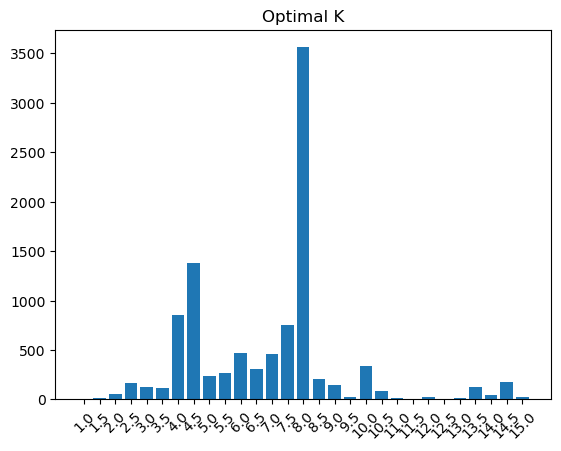

In [27]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(pd_ensemble.p1.values[0]-0.01e-5, pd_ensemble.p1.values+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(pd_ensemble.p1.values))
ax.bar(positions, counts, width=0.8)
labels = np.round(pd_ensemble.p1.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K')

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_All.png'))  

In [28]:
#print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
#print('max = ', np.max(np.array(min_p1)))

# To incorporate a wider range of uncertainty, it might make sense to use 1st and 99th percentiles.

1st =  2.5000000000000005e-05
5th =  4.000000000000001e-05
median =  7.500000000000002e-05
95th =  0.000105
99th =  0.000145


# Analyse sensitivity

In [29]:
Kt= 8e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.73 m/a/K
Basin  2 : 1.8 m/a/K
Basin  3 : 2.42 m/a/K
Basin  4 : 3.08 m/a/K
Basin  5 : 5.13 m/a/K
Basin  6 : 3.82 m/a/K
Basin  7 : 2.15 m/a/K
Basin  8 : 1.58 m/a/K
Basin  9 : 4.69 m/a/K
Basin  10 : 8.52 m/a/K
Basin  11 : 3.7 m/a/K
Basin  12 : 3.94 m/a/K
Basin  13 : 2.81 m/a/K
Basin  14 : 2.22 m/a/K
Basin  15 : 1.39 m/a/K
Basin  16 : 2.12 m/a/K
Corresponding deltaT values: [-0.25 -0.3   0.15  0.55  0.05  0.6  -0.25 -0.2   0.75  2.    0.5  -0.25
  0.45  0.   -0.2   0.15]


In [42]:
Kt= 2e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 0.84 m/a/K
Basin  2 : 0.75 m/a/K
Basin  3 : 0.96 m/a/K
Basin  4 : 1.29 m/a/K
Basin  5 : 2.36 m/a/K
Basin  6 : 1.73 m/a/K
Basin  7 : 1.12 m/a/K
Basin  8 : 0.56 m/a/K
Basin  9 : 1.86 m/a/K
Basin  10 : 2.13 m/a/K
Basin  11 : 1.72 m/a/K
Basin  12 : 1.83 m/a/K
Basin  13 : 1.15 m/a/K
Basin  14 : 0.97 m/a/K
Basin  15 : 0.46 m/a/K
Basin  16 : 0.83 m/a/K
Corresponding deltaT values: [0.5  0.25 0.8  1.5  2.   2.   0.8  0.1  2.   2.   1.95 1.3  1.25 0.75
 0.   0.7 ]


In [43]:
Kt= 15e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.94 m/a/K
Basin  2 : 2.57 m/a/K
Basin  3 : 3.71 m/a/K
Basin  4 : 4.75 m/a/K
Basin  5 : 6.42 m/a/K
Basin  6 : 5.29 m/a/K
Basin  7 : 2.39 m/a/K
Basin  8 : 2.55 m/a/K
Basin  9 : 6.54 m/a/K
Basin  10 : 11.86 m/a/K
Basin  11 : 5.08 m/a/K
Basin  12 : 5.35 m/a/K
Basin  13 : 4.44 m/a/K
Basin  14 : 3.15 m/a/K
Basin  15 : 2.41 m/a/K
Basin  16 : 3.15 m/a/K
Corresponding deltaT values: [-0.6  -0.5  -0.05  0.3  -0.75  0.15 -0.7  -0.3   0.2   1.    0.05 -0.75
  0.25 -0.25 -0.25 -0.05]
